# Brain MRI Images for Brain Tumor Detection Analysis

In [8]:
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split

# Set the desired image size for resizing
IMG_SIZE = 128

def load_images_from_folder(folder_path):
    """
    Loads and preprocesses images from a specified folder.

    Args:
        folder_path (str): Path to the folder containing images.

    Returns:
        np.array: Array of processed images.
    """
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)

        if img is not None:
            # Resize image to the specified size and normalize pixel values
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            img = img / 255.0
            images.append(img)

    return np.array(images)

# Define paths to the dataset folders
no_tumor_folder = 'brain_tumor_dataset/no'
yes_tumor_folder = 'brain_tumor_dataset/yes'

# Load and preprocess images from the specified folders
no_tumor_images = load_images_from_folder(no_tumor_folder)
yes_tumor_images = load_images_from_folder(yes_tumor_folder)

# Create corresponding labels for the images
no_tumor_labels = np.zeros(len(no_tumor_images))
yes_tumor_labels = np.ones(len(yes_tumor_images))

# Combine images and labels from both classes
images = np.concatenate((no_tumor_images, yes_tumor_images), axis=0)
labels = np.concatenate((no_tumor_labels, yes_tumor_labels), axis=0)

# Shuffle the dataset to mix the classes
indices = np.arange(images.shape[0])
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Output the shapes of the resulting datasets for verification
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")

Training set shape: (202, 128, 128, 3)
Validation set shape: (51, 128, 128, 3)


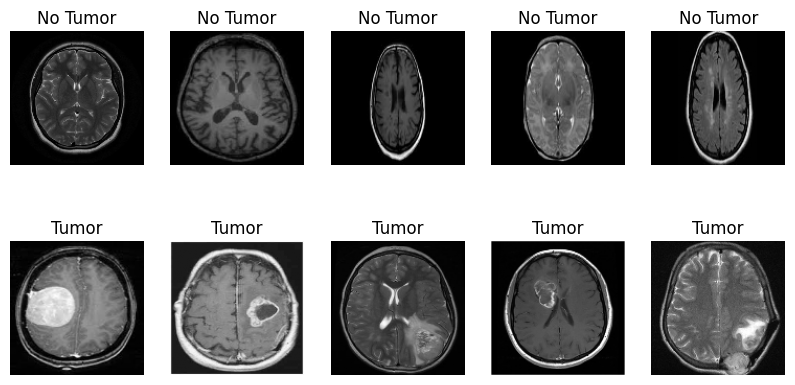

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize a sample of images from the dataset
plt.figure(figsize=(10, 5))

# Display the first 5 'No Tumor' images
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(no_tumor_images[i])
    plt.axis('off')
    plt.title('No Tumor')

# Display the first 5 'Tumor' images
for i in range(5):
    plt.subplot(2, 5, i + 6)  # Adjust the position for the second row
    plt.imshow(yes_tumor_images[i])
    plt.axis('off')
    plt.title('Tumor')

# Show the image grid
plt.show()


## Building and Training the CNN Model


In [7]:
from itertools import product

def build_model(filters1, filters2, dense_units, dropout_rate):
    model = Sequential([
        Conv2D(filters1, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(filters2, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    return model

# Define the hyperparameter grid
param_grid = {
    'filters1': [32, 64],
    'filters2': [64, 128],
    'dense_units': [128, 256],
    'dropout_rate': [0.3, 0.5]
}

# Get all combinations of parameters
all_combinations = list(product(param_grid['filters1'], param_grid['filters2'], param_grid['dense_units'], param_grid['dropout_rate']))

best_accuracy = 0
best_params = None
best_model = None

# Loop over each combination of parameters
for filters1, filters2, dense_units, dropout_rate in all_combinations:
    print(f"Training model with filters1={filters1}, filters2={filters2}, dense_units={dense_units}, dropout_rate={dropout_rate}...")
    
    model = build_model(filters1, filters2, dense_units, dropout_rate)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), verbose=0)
    
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Validation Accuracy: {val_accuracy}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = (filters1, filters2, dense_units, dropout_rate)
        best_model = model

print(f"Best parameters: {best_params} with accuracy: {best_accuracy}")


Training model with filters1=32, filters2=64, dense_units=128, dropout_rate=0.3...
Validation Accuracy: 0.8823529481887817
Training model with filters1=32, filters2=64, dense_units=128, dropout_rate=0.5...
Validation Accuracy: 0.9019607901573181
Training model with filters1=32, filters2=64, dense_units=256, dropout_rate=0.3...
Validation Accuracy: 0.843137264251709
Training model with filters1=32, filters2=64, dense_units=256, dropout_rate=0.5...
Validation Accuracy: 0.8039215803146362
Training model with filters1=32, filters2=128, dense_units=128, dropout_rate=0.3...
Validation Accuracy: 0.8235294222831726
Training model with filters1=32, filters2=128, dense_units=128, dropout_rate=0.5...
Validation Accuracy: 0.8235294222831726
Training model with filters1=32, filters2=128, dense_units=256, dropout_rate=0.3...
Validation Accuracy: 0.8235294222831726
Training model with filters1=32, filters2=128, dense_units=256, dropout_rate=0.5...
Validation Accuracy: 0.8627451062202454
Training mode

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Build the Convolutional Neural Network (CNN) model
model = Sequential([
    # First convolutional layer with 32 filters, 3x3 kernel, and ReLU activation
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),  # First max-pooling layer with 2x2 pool size

    # Second convolutional layer with 64 filters and ReLU activation
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # Second max-pooling layer

    # Third convolutional layer with 128 filters and ReLU activation
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),  # Third max-pooling layer

    # Flatten the 3D output to 1D for the dense layers
    Flatten(),

    # Fully connected dense layer with 128 units and ReLU activation
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout layer to prevent overfitting

    # Output layer with a single unit and sigmoid activation for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with the training data and validate on the validation set
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))


Epoch 1/20
7/7 [==============================] - 2s 180ms/step - loss: 0.7159 - accuracy: 0.6683 - val_loss: 0.5981 - val_accuracy: 0.8431
Epoch 2/20
7/7 [==============================] - 1s 161ms/step - loss: 0.5615 - accuracy: 0.7475 - val_loss: 0.4557 - val_accuracy: 0.8039
Epoch 3/20
7/7 [==============================] - 1s 168ms/step - loss: 0.5290 - accuracy: 0.7574 - val_loss: 0.4419 - val_accuracy: 0.8431
Epoch 4/20
7/7 [==============================] - 1s 148ms/step - loss: 0.4838 - accuracy: 0.7822 - val_loss: 0.4016 - val_accuracy: 0.8627
Epoch 5/20
7/7 [==============================] - 1s 146ms/step - loss: 0.4812 - accuracy: 0.7921 - val_loss: 0.3913 - val_accuracy: 0.8627
Epoch 6/20
7/7 [==============================] - 1s 176ms/step - loss: 0.4475 - accuracy: 0.8069 - val_loss: 0.3945 - val_accuracy: 0.8431
Epoch 7/20
7/7 [==============================] - 1s 163ms/step - loss: 0.4266 - accuracy: 0.8317 - val_loss: 0.3936 - val_accuracy: 0.8431
Epoch 8/20
7/7 [====

## Evaluation of the Model's Performance

2/2 [==============================] - 0s 25ms/step - loss: 0.3767 - accuracy: 0.8627
Validation Loss: 0.3766576647758484
Validation Accuracy: 0.8627451062202454
2/2 [==============================] - 0s 25ms/step
Classification Report:
              precision    recall  f1-score    support
0.0            0.857143  0.818182  0.837209  22.000000
1.0            0.866667  0.896552  0.881356  29.000000
accuracy       0.862745  0.862745  0.862745   0.862745
macro avg      0.861905  0.857367  0.859283  51.000000
weighted avg   0.862558  0.862745  0.862312  51.000000


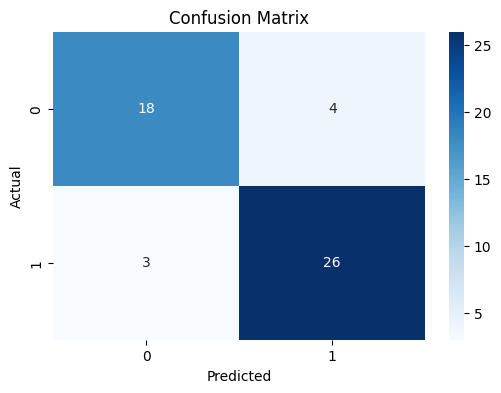

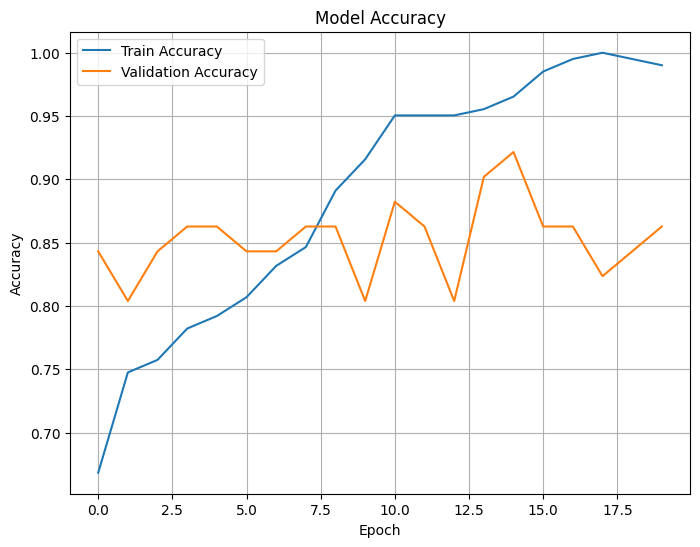

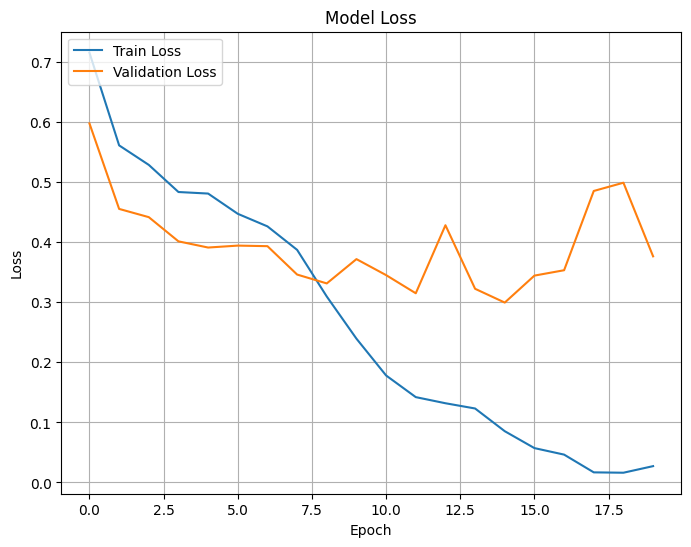

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Generate predictions on the validation set
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate a classification report and convert it to a DataFrame for better readability
report = classification_report(y_val, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("Classification Report:")
print(report_df)

# Generate and visualize the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the model's accuracy over the training epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot the model's loss over the training epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


##  Visualization of the Results


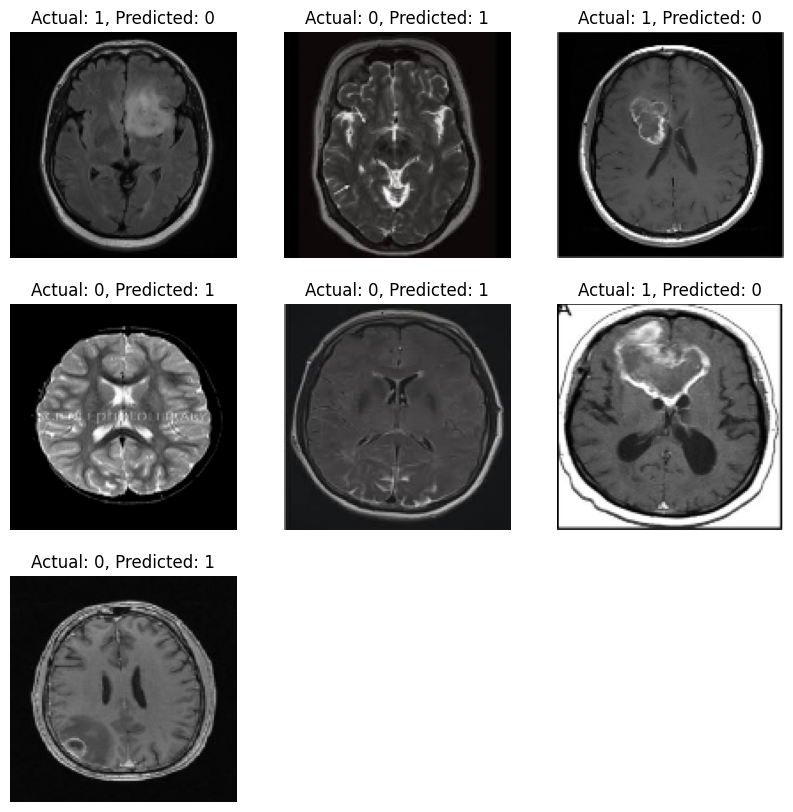

In [12]:
# Identify the indices of misclassified images
misclassified_indices = np.where(y_val != y_pred.flatten())[0]

# Visualize a sample of misclassified images
plt.figure(figsize=(10, 10))
for i, index in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_val[index])
    plt.title(f'Actual: {int(y_val[index])}, Predicted: {int(y_pred[index][0])}')
    plt.axis('off')

# Display the misclassified images
plt.show()
